# Convert pretrained PyTorch RGB Model to Single Channel Grey

## The Problem

Challenge participants will be using models pretrained on RGB data where the first convolution takes in 3 channels.
The competition data is fundamentally single channel. The images are RGB JPEGS, the R, G, and B values are always the same.

This is inefficient because:
- Data augmentation transforms will be performed on 3x more data then necessary
- Data transfer to the GPU is 3x larger than necessary
- Flops of the first convolution are approximatley 3x more than necessary

## The Solution

Convert the first convolution to single channel by summing over the channels.

Below I demonstrated PyTorch surgery on a pre-trained network to address this. Outputs are not exactly the same due to the complexity of whitening with different means and variances for R, G, and B. The final plot should demonstrate that the outputs are approximately the same, and certainly close enough for fine tuning in a dramatically different domain.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torchvision
import torch.nn

## Demonstration Image

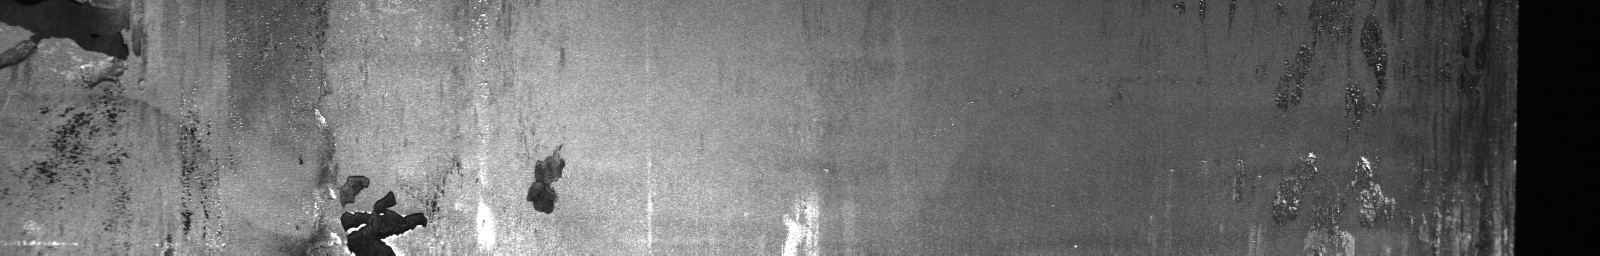

In [2]:
pil_im = Image.open(os.path.join('../input/test_images/b51cdf84f.jpg'))
pil_im

In [3]:
model_rgb = torchvision.models.resnet18(pretrained=True)
model_rgb.eval()

transforms_rgb = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 113079856.14it/s]


In [4]:
model_grey = torchvision.models.resnet18(pretrained=True)
weight_rgb = model_grey.conv1.weight

# Sum over the weights to convert the kernel
weight_grey = weight_rgb.sum(dim=1, keepdim=True)
bias = model_grey.conv1.bias

# Instantiate a new convolution module and set weights
model_grey.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_grey.conv1.weight = torch.nn.Parameter(weight_grey)
model_grey.conv1.bias = bias

model_grey.eval()

transforms_grey = torchvision.transforms.Compose([
    # Reduce to a single channel. We could use x.convert('L') here, but this is probably fewer operations and the result is the same.
    torchvision.transforms.Lambda(lambda x: Image.fromarray(np.asarray(pil_im)[:, :, 0], mode='L')),
    
    # These image transforms are now on a single channel image instead of 3
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    
    # Normalization means and stds can be taken as the average of the rgb values
    torchvision.transforms.Normalize(mean=[np.mean([0.485, 0.456, 0.406])], std=[np.mean([0.229, 0.224, 0.225])])
])

In [5]:
tensor_rgb = transforms_rgb(pil_im)
batch_tensor_rgb = tensor_rgb.unsqueeze(0)

with torch.no_grad():
    classes_rgb = model_rgb(batch_tensor_rgb)
    classes_rgb = classes_rgb.squeeze().numpy()

In [6]:
tensor_grey = transforms_grey(pil_im)
batch_tensor_grey = tensor_grey.unsqueeze(0)

with torch.no_grad():
    classes_grey = model_grey(batch_tensor_grey)
    classes_grey = classes_grey.squeeze().numpy()

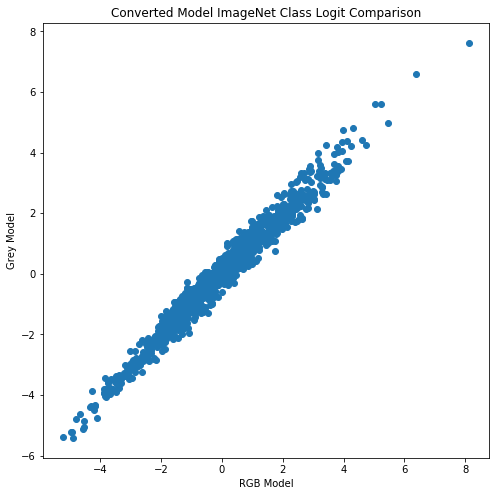

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(classes_rgb, classes_grey)
plt.xlabel('RGB Model')
plt.ylabel('Grey Model')
plt.title('Converted Model ImageNet Class Logit Comparison')
plt.show()

# Classification

In [8]:
import urllib.request
import json

response = urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt')
data = response.read()
label_mapping = eval(data)

label_mapping[np.argmax(classes_grey)]

'fountain'

For the curious... it's a fountain.